# Setup

In [120]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# import mpld3
# mpld3.enable_notebook()
# mpld3.disable_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
torch.__version__

'1.3.1'

In [3]:
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import models

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [5]:
import os
import yaml
import boto3
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import albumentations

In [6]:
matplotlib.__version__, albumentations.__version__

('3.1.2', '0.4.3')

In [7]:
config = yaml.load(open('config/config.yml'), Loader=yaml.BaseLoader)

In [8]:
os.environ['AWS_ACCESS_KEY_ID'] = config['aws']['aws_access_key_id']
os.environ['AWS_SECRET_ACCESS_KEY'] = config['aws']['aws_secret_access_key']
os.environ['AWS_DEFAULT_REGION'] = config['aws']['aws_default_region']
s3 = boto3.client('s3')

In [9]:
model_path = 'model/unet-dan.pt'
am_segm_bucket = 'am-segm'

In [366]:
from am.segment.utils import convert_to_image, plot_images_row

def predict_plot_batch(model, inputs, targets):
    targets_pred = torch.sigmoid(model(inputs.to('cuda')))
    
    n = min(len(inputs), len(targets))
    for i in range(n):
        plot_images_row([
            convert_to_image(targets[i]),
            convert_to_image(inputs[i]),
#             convert_to_image(targets_pred[i]),
#             (np.sqrt(convert_to_image(targets_pred[i])) > 0.5).astype(int),
            (convert_to_image(targets_pred[i]) > 0.5).astype(int)
        ], titles=['Labels', 'Inputs', 'Predicted', 'Pred mask'])

def predict_plot(model, dl, batch_n=1):
    for i, (inputs, targets) in enumerate(dl):
        predict_plot_batch(model, inputs, targets)
        if i == batch_n - 1: break

def create_uniq_exp_group(dl):
    return set(map(tuple, dl.dataset.image_df[['experiment', 'group']].values))

# Train Model

In [339]:
import pandas as pd
from sklearn.model_selection import GroupKFold, KFold
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter
import albumentations as albu

from am.segment.dataset import (
    AMDataset, create_ds, create_dl,
    train_transform, valid_transform, default_transform
)
from am.segment.loss import jaccard, CombinedLoss
from am.segment.model import UNet11, AlbuNet, UNet16
from am.segment.train import train_loop
from am.segment.utils import plot_images_row
from am.segment.image_utils import create_normalizer
from am.utils import plot_overlay, save_model, load_model

In [370]:
batch_size = 4
train_paths = [
    'data/DAN_AMs_6Aug2019/manual_tiles',
    'data/Mouse_16_slideD_DAN_FD_stained_left_BF/manual_tiles',
    'data/Mouse16_PFA_SlideN_sample/left/manual_tiles'
]
# train_ds += load_ds('data/DAN_AMs_6Aug2019/pseudo_tiles',
#                      train_transform(), size=None)
# train_ds += load_ds('data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles',
#                      train_transform(), size=None)
train_dl = create_dl(
    train_paths,
    transform=train_transform(),
    path_image_n=16, shuffle=True, batch_size=batch_size
)
valid_paths = [
#     'data/Mouse16_PFA_SlideN_sample/left/manual_tiles',
    'data/Mouse16_PFA_SlideN_sample/right/tiles'
]
valid_dl = create_dl(
    valid_paths,
    transform=valid_transform(),
    path_image_n=16, shuffle=False, batch_size=batch_size*2
)
len(train_dl.dataset), len(valid_dl.dataset)

(48, 16)

In [371]:
train_uniq_exp_group = create_uniq_exp_group(train_dl)
valid_uniq_exp_group = create_uniq_exp_group(valid_dl)
train_valid_intersection = train_uniq_exp_group.intersection(valid_uniq_exp_group)
assert train_valid_intersection == set(), train_valid_intersection

In [388]:
train_dl.dataset.image_df

experiment            group  \
0                        DAN_AMs_6Aug2019  2-real_well_7-F   
1                        DAN_AMs_6Aug2019  2-real_well_7-F   
0                        DAN_AMs_6Aug2019  2-real_well_7-F   
1                        DAN_AMs_6Aug2019  2-real_well_7-F   
0                        DAN_AMs_6Aug2019  2-real_well_7-F   
1                        DAN_AMs_6Aug2019  2-real_well_7-F   
0                        DAN_AMs_6Aug2019  2-real_well_7-F   
1                        DAN_AMs_6Aug2019  2-real_well_7-F   
0                        DAN_AMs_6Aug2019  2-real_well_7-F   
1                        DAN_AMs_6Aug2019  2-real_well_7-F   
0                        DAN_AMs_6Aug2019  2-real_well_7-F   
1                        DAN_AMs_6Aug2019  2-real_well_7-F   
0                        DAN_AMs_6Aug2019  2-real_well_7-F   
1                        DAN_AMs_6Aug2019  2-real_well_7-F   
0                        DAN_AMs_6Aug2019  2-real_well_7-F   
1                        DAN_AMs_6Aug2019  2-real_well_7-F   
0  Mouse_16_slideD_DAN_FD_stained_left_BF            Well8   
1  Mouse_16_slideD_DAN_FD_stained_left_BF            Well2   
0  Mouse_16_slideD_DAN_FD_stained_left_BF            Well8   
1  Mouse_16_slideD_DAN_FD_stained_left_BF            Well2   
0  Mouse_16_slideD_DAN_FD_stained_left_BF            Well8   
1  Mouse_16_slideD_DAN_FD_stained_left_BF            Well2   
0  Mouse_16_slideD_DAN_FD_stained_left_BF            Well8   
1  Mouse_16_slideD_DAN_FD_stained_left_BF            Well2   
0  Mouse_16_slideD_DAN_FD_stained_left_BF            Well8   
1  Mouse_16_slideD_DAN_FD_stained_left_BF            Well2   
0  Mouse_16_slideD_DAN_FD_stained_left_BF            Well8   
1  Mouse_16_slideD_DAN_FD_stained_left_BF            Well2   
0  Mouse_16_slideD_DAN_FD_stained_left_BF            Well8   
1  Mouse_16_slideD_DAN_FD_stained_left_BF            Well2   
0  Mouse_16_slideD_DAN_FD_stained_left_BF            Well8   
1  Mouse_16_slideD_DAN_FD_stained_left_BF            Well2   
0                                    left            Well5   
1                                    left            Well5   
0                                    left            Well5   
1                                    left            Well5   
0                                    left            Well5   
1                                    left            Well5   
0                                    left            Well5   
1                                    left            Well5   
0                                    left            Well5   
1                                    left            Well5   
0                                    left            Well5   
1                                    left            Well5   
0                                    left            Well5   
1                                    left            Well5   
0                                    left            Well5   
1                                    left            Well5   

                                                path  
0  data/DAN_AMs_6Aug2019/manual_tiles/2-real_well...  
1  data/DAN_AMs_6Aug2019/manual_tiles/2-real_well...  
0  data/DAN_AMs_6Aug2019/manual_tiles/2-real_well...  
1  data/DAN_AMs_6Aug2019/manual_tiles/2-real_well...  
0  data/DAN_AMs_6Aug2019/manual_tiles/2-real_well...  
1  data/DAN_AMs_6Aug2019/manual_tiles/2-real_well...  
0  data/DAN_AMs_6Aug2019/manual_tiles/2-real_well...  
1  data/DAN_AMs_6Aug2019/manual_tiles/2-real_well...  
0  data/DAN_AMs_6Aug2019/manual_tiles/2-real_well...  
1  data/DAN_AMs_6Aug2019/manual_tiles/2-real_well...  
0  data/DAN_AMs_6Aug2019/manual_tiles/2-real_well...  
1  data/DAN_AMs_6Aug2019/manual_tiles/2-real_well...  
0  data/DAN_AMs_6Aug2019/manual_tiles/2-real_well...  
1  data/DAN_AMs_6Aug2019/manual_tiles/2-real_well...  
0  data/DAN_AMs_6Aug2019/manual_tiles/2-real_well...  
1  data/DAN_AMs_6Aug2019/manual_tiles/2-real_well...  
0  data/Mouse_16_slideD_DAN_FD_stained_left_BF/ma...  
1 

## Visualize Images

In [372]:
image, _ = train_dl.dataset[0]

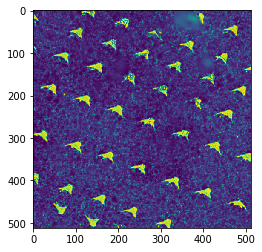

In [373]:
plt.imshow(image[0]);

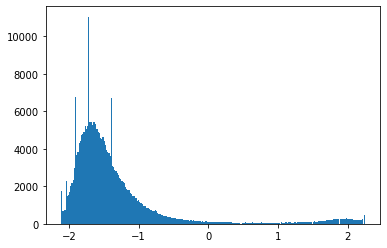

In [374]:
plt.hist(image[0].flatten(), bins=256);

In [375]:
image, _ = valid_dl.dataset[0]

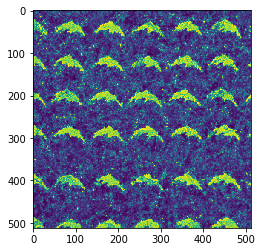

In [376]:
plt.imshow(image[0]);

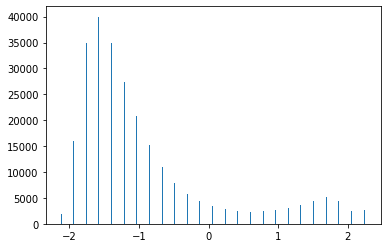

In [377]:
plt.hist(image[0].flatten(), bins=256);

Train data


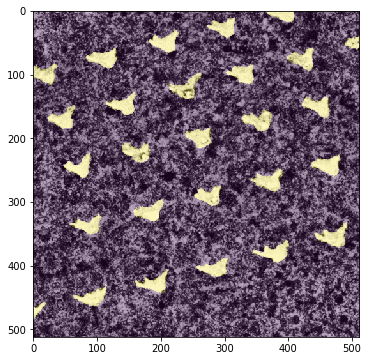

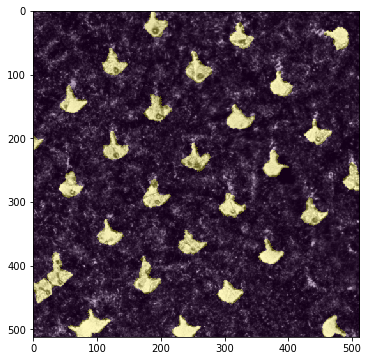

Valid data


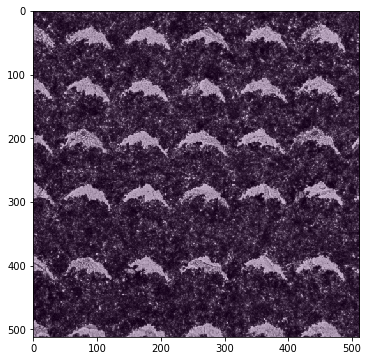

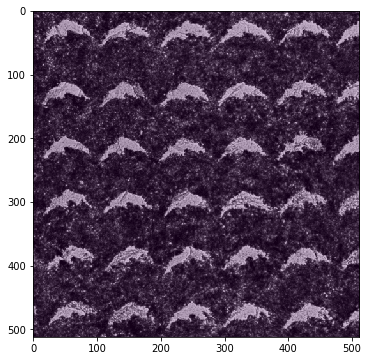

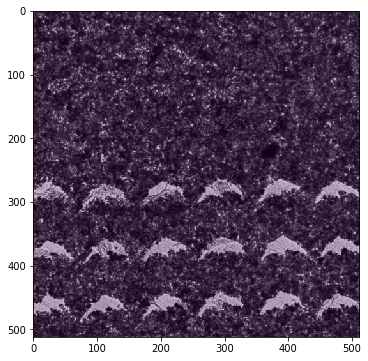

In [378]:
print('Train data')
n = 2
rinds = np.random.randint(0, len(train_dl.dataset), n)
for i in rinds:
    img, mask = train_dl.dataset[i]
#     img_no_tfm, _ = train_no_tfm_ds[i]
    fig = plot_overlay(img, mask, figsize=(6, 6))
#     fig = plot_images_row([img_no_tfm, img])
    plt.show()
#     if i == n - 1: break
    
print('Valid data')
n = 3
for i, (img, mask) in enumerate(valid_dl.dataset):
    plot_overlay(img, mask, figsize=(6, 6))
    plt.show()
    if i == n - 1: break

## Train

In [379]:
import segmentation_models_pytorch as smp

# log_dir = 'runs/smp-se_resnext50_32x4d-jacc05'
# writer = SummaryWriter(log_dir, flush_secs=1)
# writer = None

n_epochs = 10
lr_dec = 3e-2

# n_epochs = 10
# lr_enc = 3e-4
# lr_dec = 1e-3

model = smp.Unet(encoder_name='se_resnext50_32x4d', decoder_use_batchnorm=True)
# model = smp.Unet(encoder_name='resnet50', decoder_use_batchnorm=True)

optimizer = torch.optim.Adam([
#     {'params': model.encoder.parameters(), 'lr': lr_enc},
    {'params': model.decoder.parameters(), 'lr': lr_dec},
])
criterion = CombinedLoss(bce_weight=0.5, jaccard=True, smooth=1e-15)

train_loop(
    model, train_dl, valid_dl, optimizer, criterion, n_epochs
)

Epoch 1/10
----------
............
Train loss: 0.98482, train metric: 0.63927
..
Valid loss: 28.68023, valid metric: 0.00000
0 min 19 sec
Epoch 2/10
----------
............
Train loss: 0.64358, train metric: 0.74883
..
Valid loss: 24.37142, valid metric: 0.00000
0 min 38 sec
Epoch 3/10
----------
............
Train loss: 0.44019, train metric: 0.79971
..
Valid loss: 23.93758, valid metric: 0.00000
0 min 58 sec
Epoch 4/10
----------
............
Train loss: 0.31456, train metric: 0.81176
..
Valid loss: 23.67099, valid metric: 0.00000
1 min 18 sec
Epoch 5/10
----------
............
Train loss: 0.24078, train metric: 0.82617
..
Valid loss: 24.09827, valid metric: 0.00000
1 min 37 sec
Epoch 6/10
----------
............
Train loss: 0.20584, train metric: 0.82860
..
Valid loss: 23.95662, valid metric: 0.00000
1 min 56 sec
Epoch 7/10
----------
............
Train loss: 0.18030, train metric: 0.83351
..
Valid loss: 23.94077, valid metric: 0.00000
2 min 16 sec
Epoch 8/10
----------
............

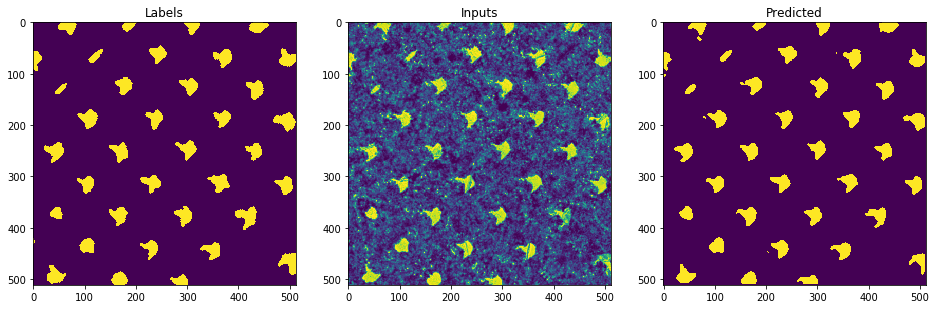

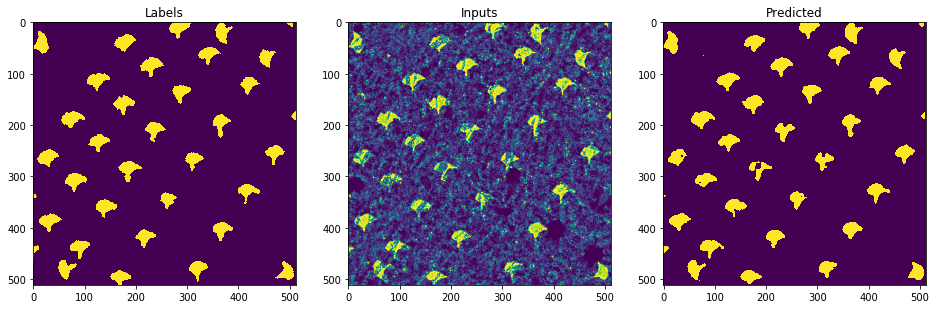

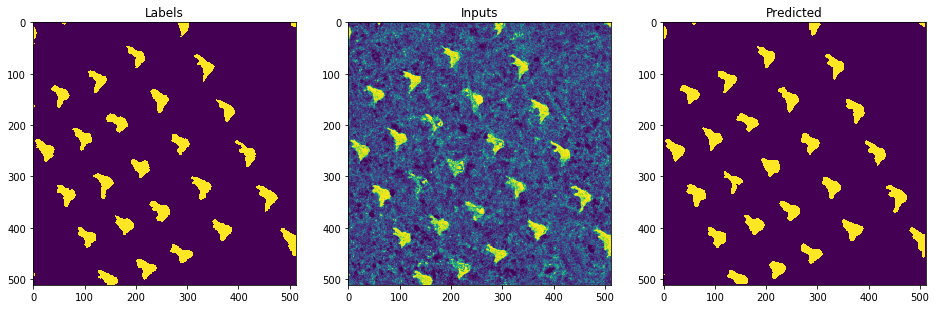

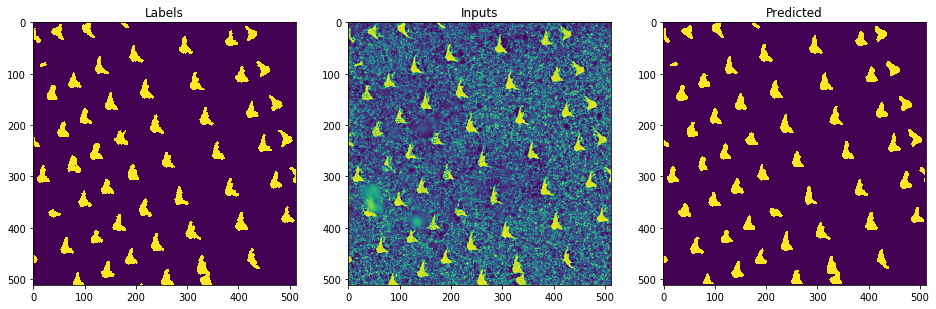

In [380]:
predict_plot(model, train_dl)

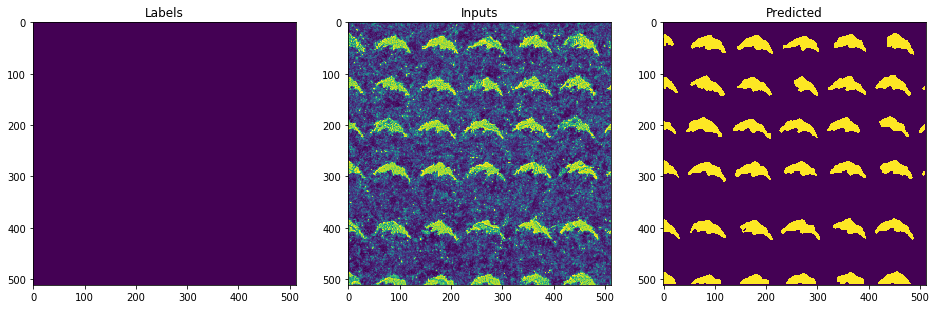

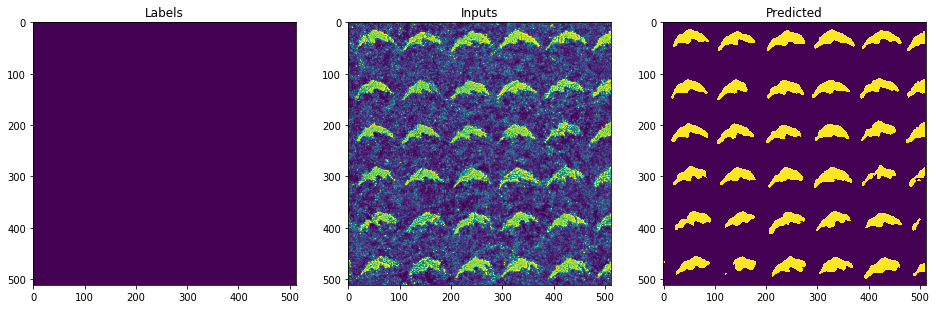

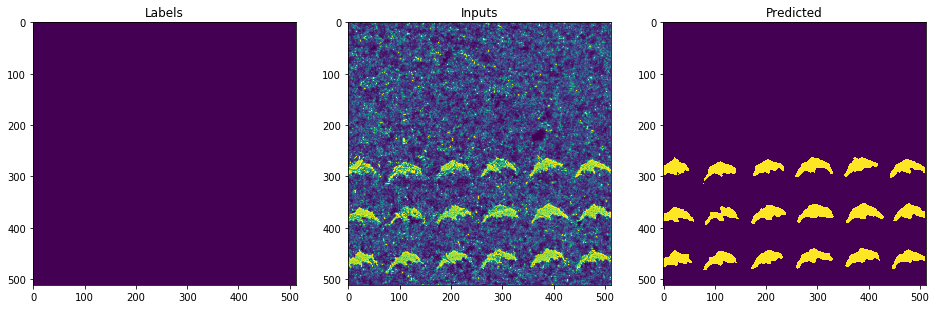

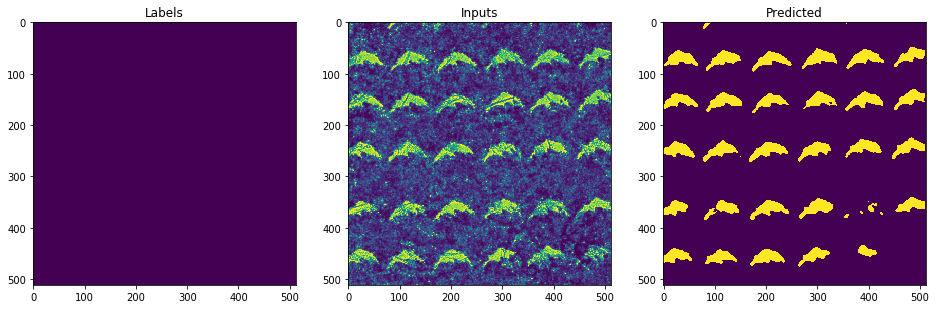

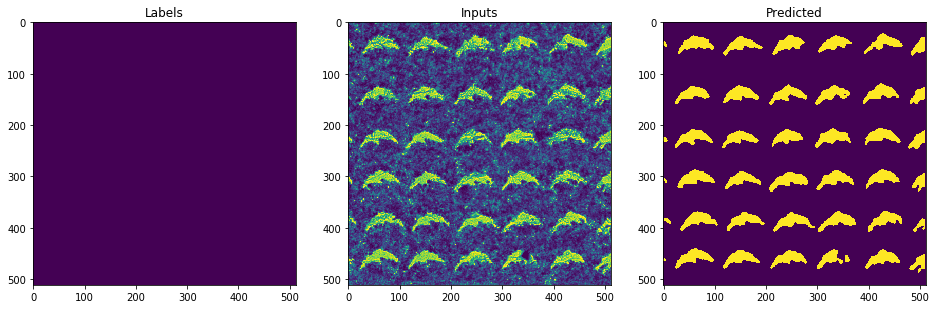

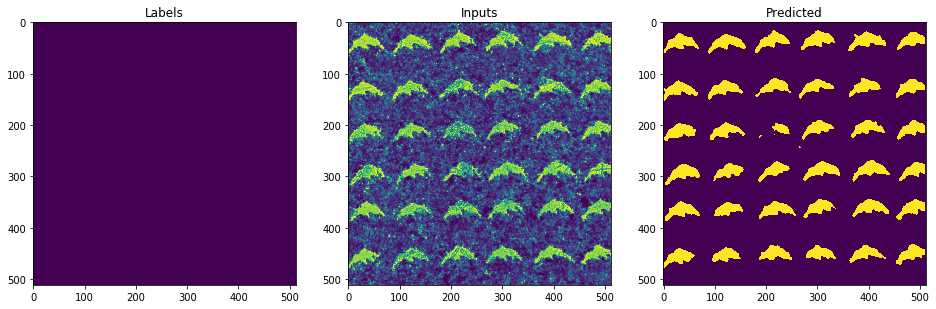

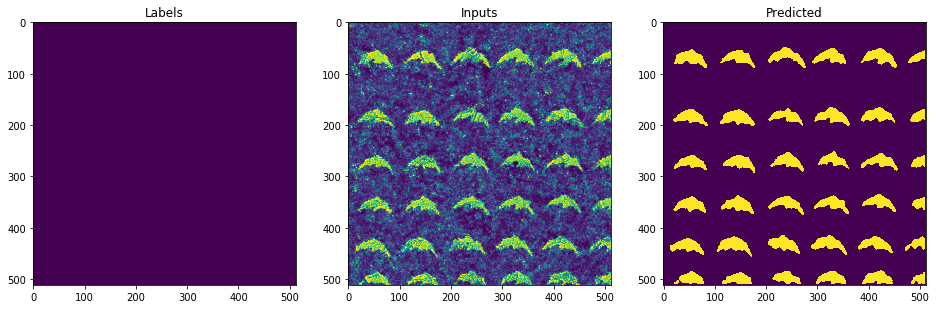

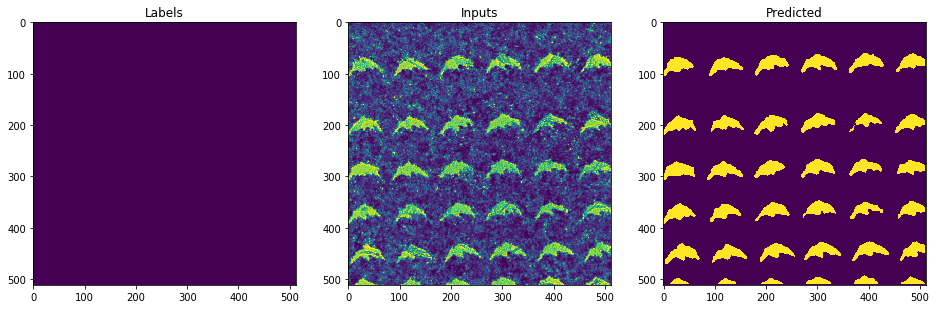

In [381]:
predict_plot(model, valid_dl)

In [382]:
save_model(model, model_path)

In [383]:
n_epochs = 10
lr_enc, lr_dec = 3e-4, lr_dec/10

model = load_model(model_path)
optimizer = torch.optim.Adam([
    {'params': model.encoder.parameters(), 'lr': lr_enc},
    {'params': model.decoder.parameters(), 'lr': lr_dec},
])
criterion = CombinedLoss(bce_weight=0.5, jaccard=True, smooth=1e-15)

train_loop(model, train_dl, valid_dl,
           optimizer, criterion, n_epochs=n_epochs)

Epoch 1/10
----------
............
Train loss: 0.14544, train metric: 0.84084
..
Valid loss: 23.76420, valid metric: 0.00000
0 min 20 sec
Epoch 2/10
----------
............
Train loss: 0.13847, train metric: 0.84777
..
Valid loss: 23.85906, valid metric: 0.00000
0 min 41 sec
Epoch 3/10
----------
............
Train loss: 0.13320, train metric: 0.85106
..
Valid loss: 23.93382, valid metric: 0.00000
1 min 1 sec
Epoch 4/10
----------
............
Train loss: 0.12964, train metric: 0.85418
..
Valid loss: 23.85500, valid metric: 0.00000
1 min 21 sec
Epoch 5/10
----------
............
Train loss: 0.12889, train metric: 0.85270
..
Valid loss: 23.98083, valid metric: 0.00000
1 min 40 sec
Epoch 6/10
----------
............
Train loss: 0.12533, train metric: 0.85555
..
Valid loss: 23.86640, valid metric: 0.00000
2 min 0 sec
Epoch 7/10
----------
............
Train loss: 0.12026, train metric: 0.86126
..
Valid loss: 23.91352, valid metric: 0.00000
2 min 20 sec
Epoch 8/10
----------
............
T

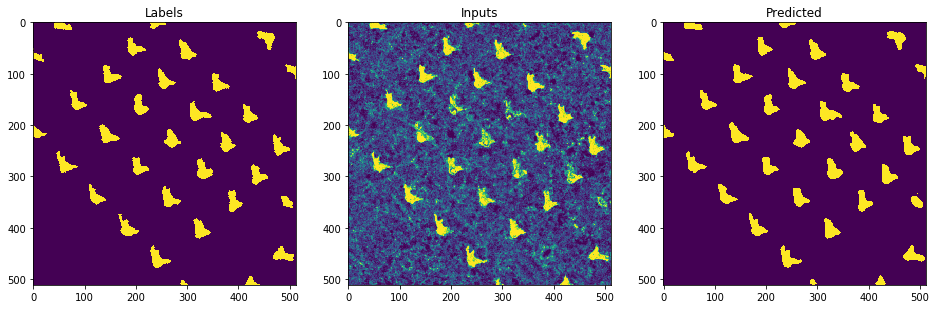

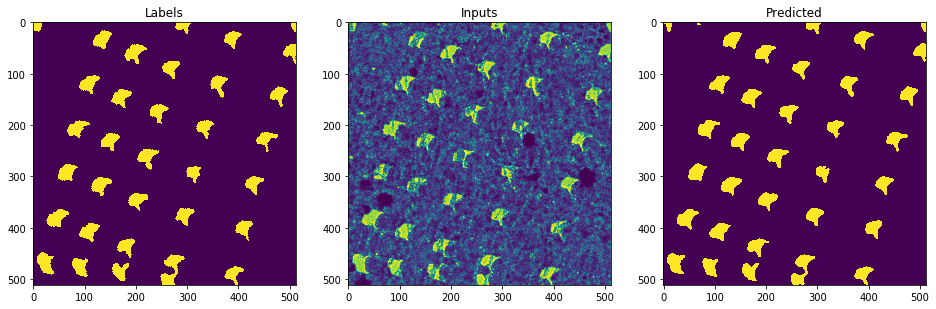

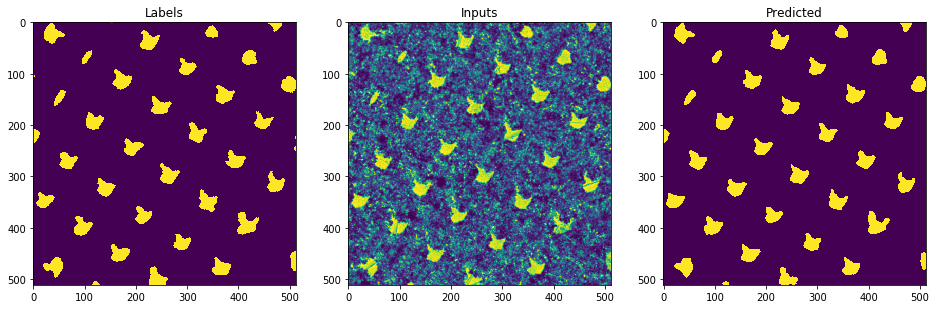

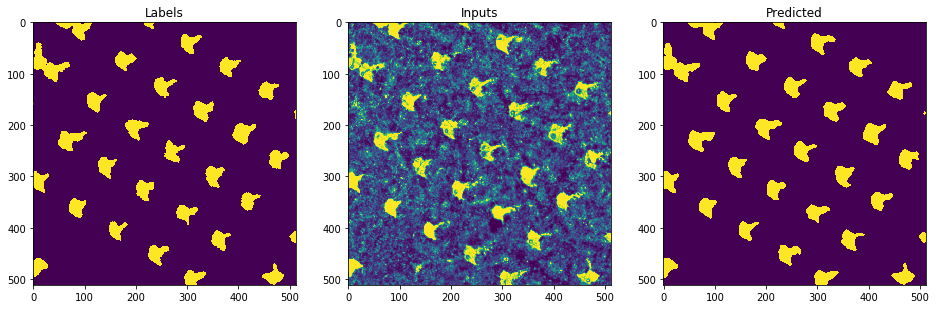

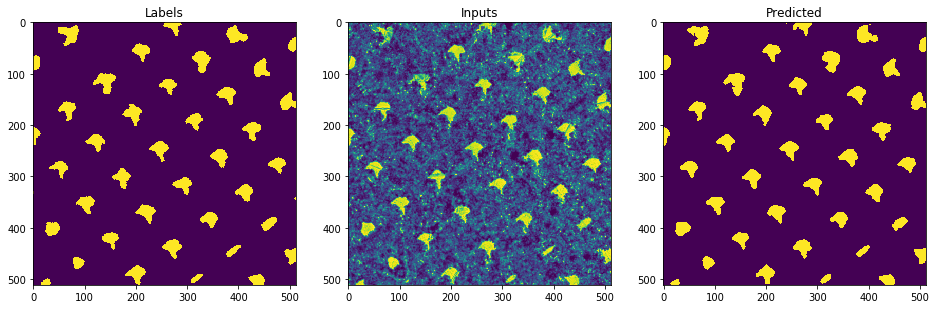

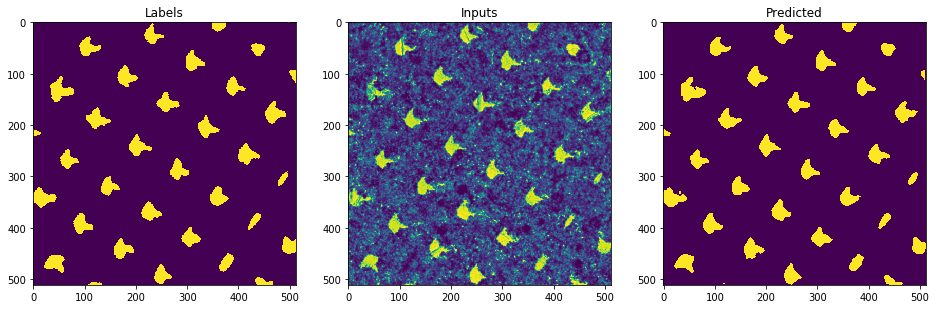

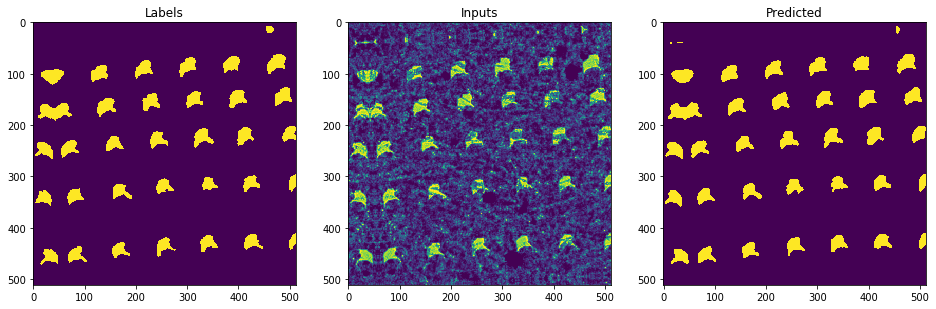

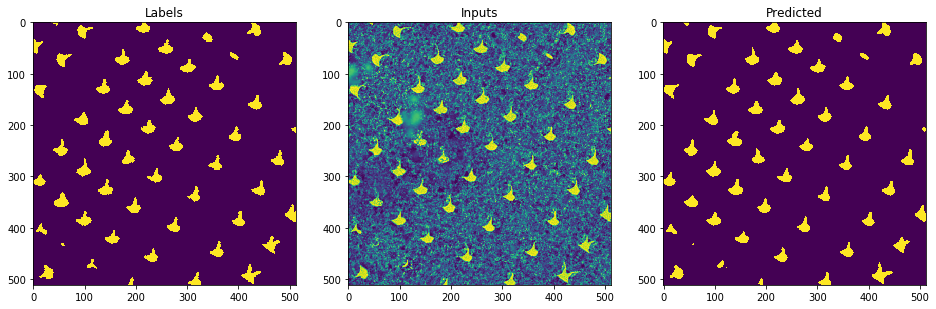

In [384]:
predict_plot(model, train_dl, 2)

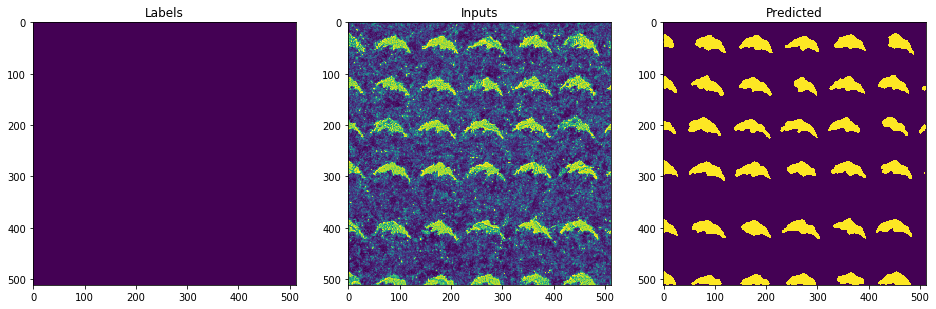

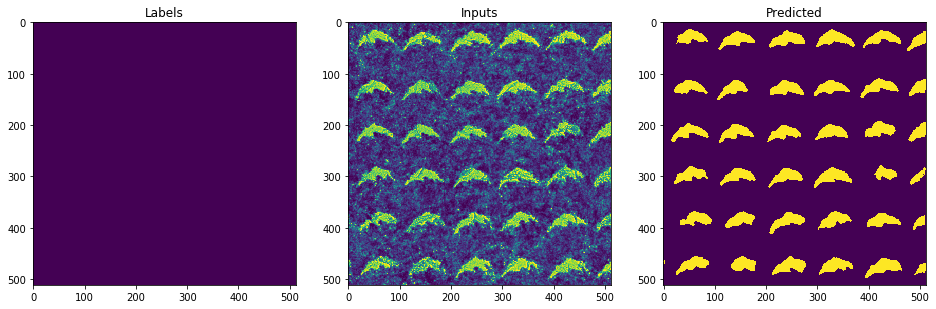

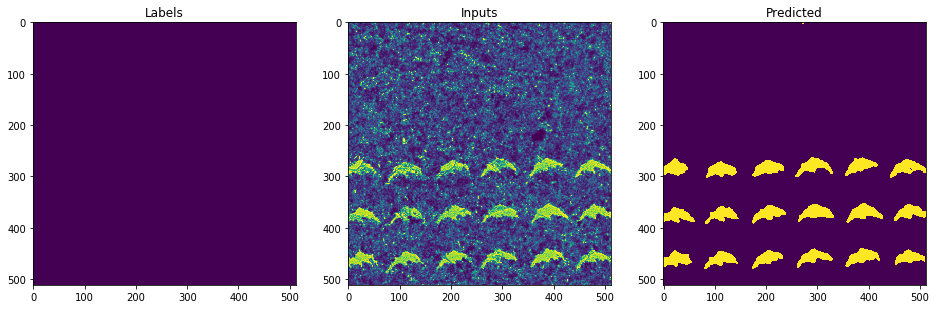

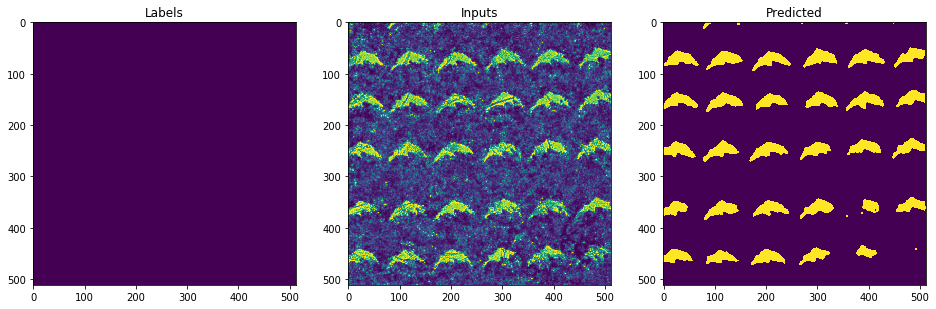

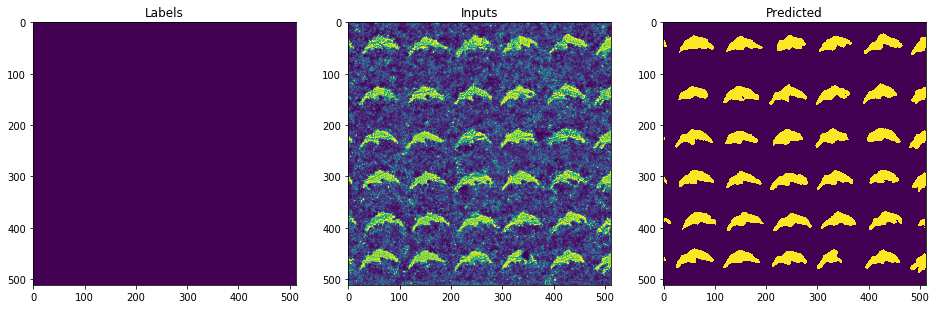

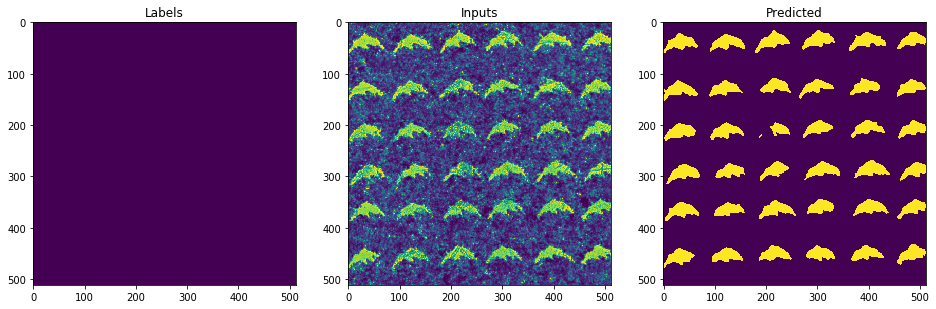

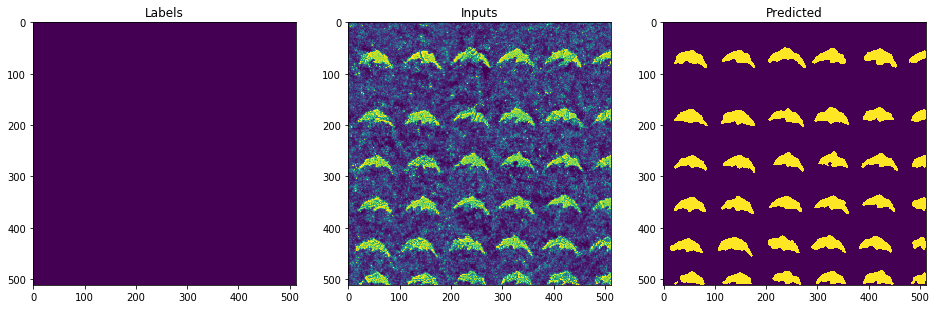

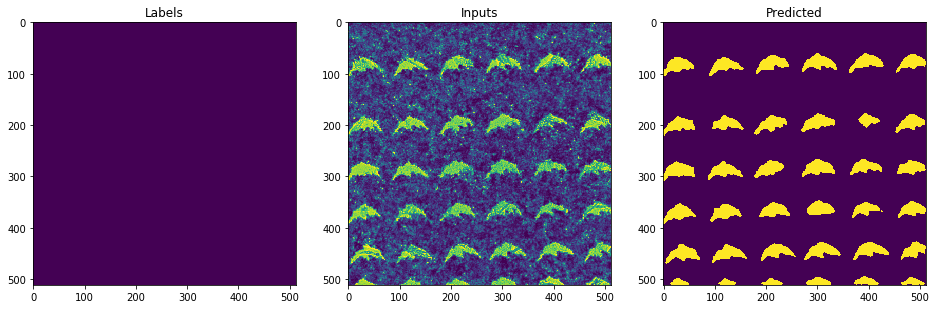

In [385]:
predict_plot(model, valid_dl, 1)

In [386]:
save_model(model, model_path)
s3.upload_file(model_path, am_segm_bucket, model_path)

# Predict

In [361]:
from am.utils import load_model

In [362]:
model = load_model(model_path)

In [364]:
test_dl = create_dl(
    ['data/Mouse16_PFA_SlideN_sample/right/tiles'],
    transform=valid_transform(),
    path_image_n=16,
    batch_size=8
)
len(test_dl.dataset)

16

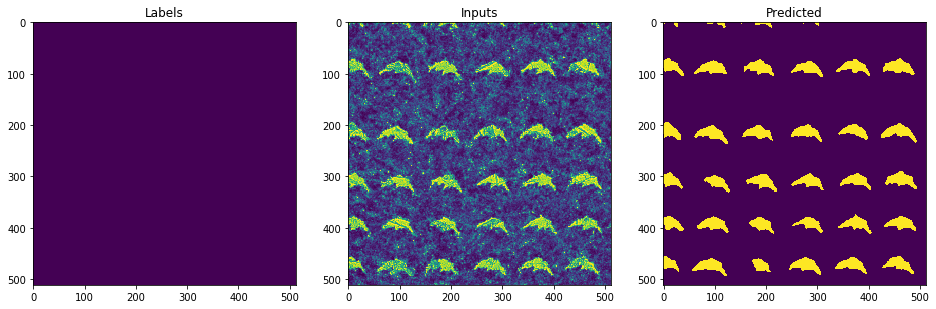

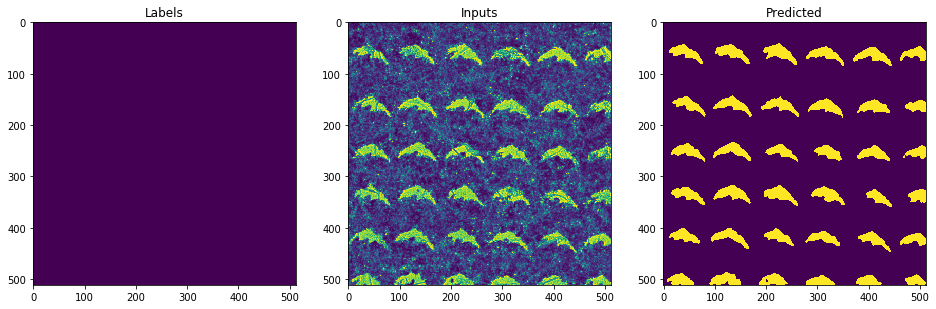

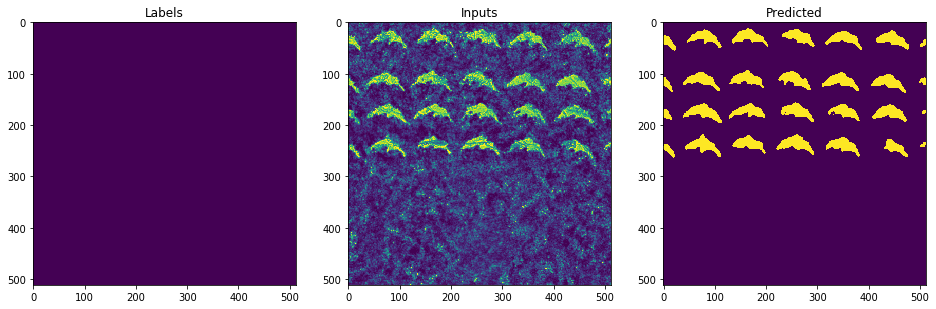

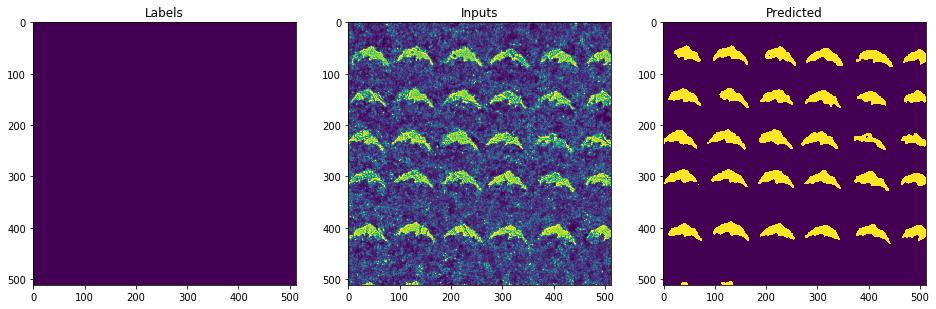

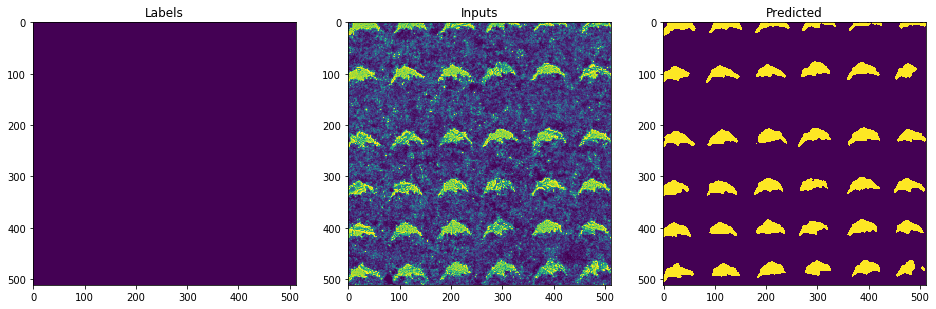

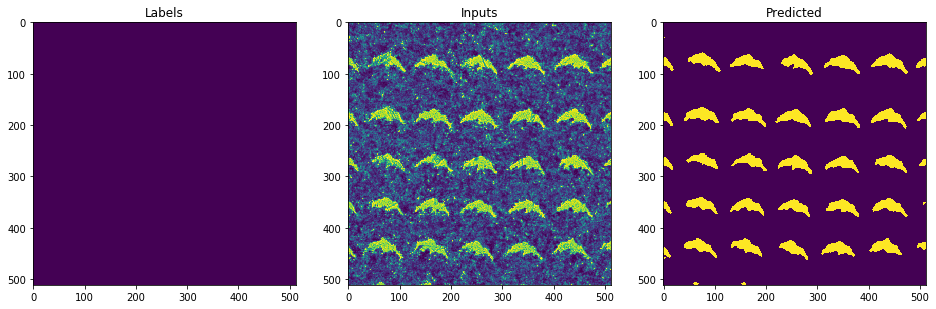

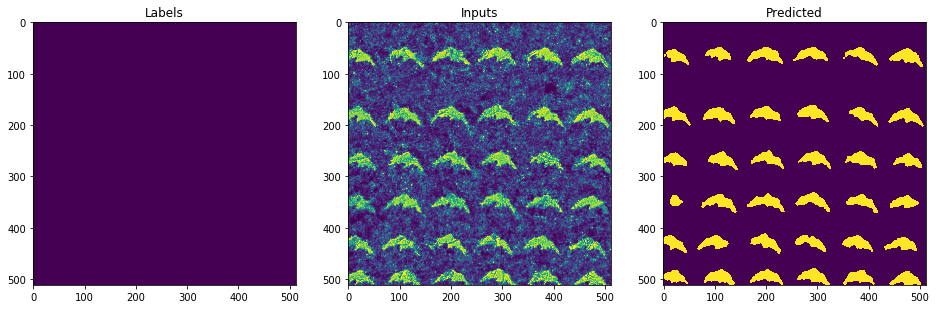

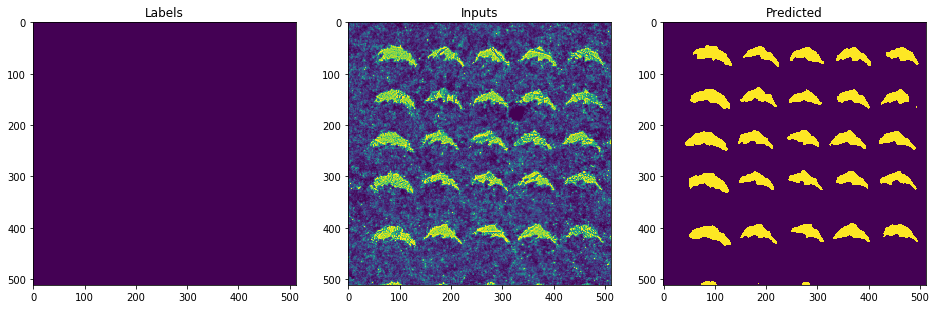

In [365]:
predict_plot(model, test_dl)

# Save Predictions

In [183]:
import json
from shutil import copy, rmtree
from am.utils import read_image, save_overlay
from am.segment.predict import predict_save
from am.segment.preprocess import stitch_tiles_at_path, overlay_images_with_masks

In [184]:
valid_ds_path

PosixPath('data/Mouse_16_slideD_DAN_FD_stained_left_BF')

In [185]:
ds = load_ds(valid_ds_path / 'tiles', valid_transform())
predict_save(model, ds, pred_path=valid_ds_path / 'pseudo_tiles')

Well7 batches processed
Well3
Well7
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/000.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/000.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/001.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/001.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/002.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/002.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/003.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/003.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/004.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/004.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/005.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/005.png
data/Mouse_16_slideD_DAN_FD_stained_left

data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/078.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/078.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/079.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/079.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/080.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/080.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/081.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/081.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/082.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/082.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/083.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/083.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/084.pn

data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/156.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/157.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/157.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/158.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/158.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/159.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/159.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/160.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/160.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/161.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/161.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/162.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/162.png


data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/010.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/010.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/011.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/011.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/012.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/012.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/013.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/013.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/014.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/014.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/015.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/015.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/016.pn

data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/063.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/064.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/064.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/065.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/065.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/066.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/066.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/067.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/067.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/068.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/068.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/069.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/069.png


data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/142.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/143.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/143.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/144.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/144.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/145.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/145.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/146.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/146.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/147.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/147.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/148.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/148.png


data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/196.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/196.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/197.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/197.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/198.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/198.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/199.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/199.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/200.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/200.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/201.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/201.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/202.pn

In [186]:
for group_path in (valid_ds_path / 'tiles').iterdir():
    meta = json.load(open(group_path / 'meta.json'))
    break
meta

{'orig_image': {'h': 12816, 'w': 8177},
 'image': {'h': 7680, 'w': 4900},
 'tile': {'rows': 15, 'cols': 15, 'size': 512}}

In [187]:
stitch_tiles_at_path(
    valid_ds_path / 'pseudo_tiles',
    overwrite=True,
    meta=meta,
)

In [188]:
overlay_images_with_masks(valid_ds_path / 'tiles_stitched')

# TTA Experiments

In [ ]:
import albumentations.augmentations.functional as F
from albumentations.pytorch.transforms import img_to_tensor

In [ ]:
normalize = albu.Normalize(p=1)

In [ ]:
i = 13
image_path = valid_ds.image_df.iloc[i].path
image = cv2.imread(str(image_path))
image.shape

In [ ]:
plt.imshow(image)

In [ ]:
# plt.imshow(F.hflip(image))

In [ ]:
plt.imshow(normalize.apply(image))

In [ ]:
# tta_tfm = [lambda im: im, F.hflip, F.vflip, lambda im: F.vflip(F.hflip(im))]
# tta_tfm = [
#     lambda im: im,
#     lambda im: albu.CLAHE()(image=im)['image']
# ]

# for _ in range(5):
#     plt.imshow(tfm.apply(image)[:,:,0])
#     plt.show()

In [ ]:

tensors = [img_to_tensor(normalize.apply(tfm.apply(image)['image'])) for tfm in tta_tfm]

In [ ]:
batch = torch.stack(tensors)
batch.shape

In [ ]:
probs = torch.sigmoid(model(batch.to('cuda')))
probs.shape

In [ ]:
# plt.imshow(convert_to_image(probs[0]))

In [ ]:
# plt.imshow(F.hflip(convert_to_image(probs[1])))

In [ ]:
pred_masks = [convert_to_image(prob) for prob in probs]
pred_mask_mean = np.mean(pred_masks, axis=0)
pred_mask_mean.shape

In [ ]:
image.shape

In [ ]:
fig = plot_images_row([image[:,:,0], pred_masks[0] > 0.5, pred_masks[1] > 0.5, pred_mask_mean > 0.5])